In [247]:
import numpy as np

# maximal clique problem
# target function is xT*A*x + some regularization term
# with x being an n-dimensional simplex
# (feasible set consists of probability simplexes)
# and A - a {0,1} graph adjacency matrix

def maxclique_target(A: np.ndarray, x:np.ndarray, p: int=0.5):
    '''
    Target function for the Maximal Clique Problem.
    '''
    return np.matmul(x.T,np.matmul(A,x)) + p*np.linalg.norm(x)**2

def maxclique_grad(A: np.ndarray, x: np.ndarray, penalty: str = 'l2', p: int = None, alpha: float = None, beta: float = None, eps: float = None):
    """
    Gradient calculation for the Maximal Clique Problem.

    A: a R^NxN adjacency matrix;
    x: a R^N vector;
    penalty: {'l2', 'f1', 'f2'} string specifying the type of penalty to use; defaults to l2;
    p, alpha, beta, eps: penalty parameters.
    """
    dp = 2*x
    if str.lower(penalty) == 'f1':
        raise NotImplementedError
    if str.lower(penalty) == 'f2':
        if beta <= 0 or alpha < 0 or alpha >= (2/beta**2):
            raise ValueError
        dp = alpha*np.sum(-beta*np.exp(-beta*x))

    return np.dot((A + A.T), x) + dp

def maxclique_lmo(grad):
    """
    LMO for the maximal clique problem. 
    The feasible set is the unit simplex, so return a [0,...,1,...,0] vector with 1 in place of the lowest element of the gradient.
    """
    e = np.zeros(shape=grad.shape[-1])
    idxmin = np.argmin(grad)
    e[idxmin] = 1
    return e

def frankwolfe(A: np.ndarray, x_0: float, grad=maxclique_grad, lmo=maxclique_lmo, max_iter: int = 10000, stepsize: float = None):
    '''
    Basic Frank-Wolfe algorithm.

    A: graph adjacency matrix;
    x_0: starting point;
    grad: gradient f-n;
    lmo: linear oracle;
    max_iter: max. nr of iterations;
    stepsize: defaults to 2/(k+2), step defined as (1-stepsize)*x_k + stepsize*x_k_hat.
    '''
    x_hist = [x_0]
    s_hist = []
    for k in range(max_iter):
        s = lmo(grad(A, x_hist[-1]))
        gamma = 2/(k+2) if stepsize is None else stepsize
        x_next = (1-gamma)*x_hist[-1] + gamma*s

        x_hist.append(x_next)
        s_hist.append(s)
    return x_hist, s_hist


In [250]:
grad = np.array([-1,0,1523,3,-4])

In [251]:
np.where(grad < 0, grad, 0)

array([-1,  0,  0,  0, -4])

In [2]:
from matplotlib import pyplot as plt

In [223]:
def make_test_graph(n, p):
    r = [0,1]
    A = np.tril(np.random.default_rng().choice(a=r, size=(n,n),p=[1-p, p]), k=-1)
    A = A + A.T
    # for i in range(n):
    #     A[i,i] = 1
    return A

def draw_graph(A):
    import networkx as nx
    A_ = np.copy(A)
    for i in range(A_.shape[0]):
        A_[i,i] = 0
    G = nx.Graph(A_)
    nx.draw(G, labels={i:f'{i}' for i in range(A.shape[0])})

In [185]:
A = np.array([
    [0,1,1,1,0],
    [1,0,0,0,1],
    [1,0,0,1,1],
    [1,0,1,0,1],
    [0,1,1,1,0]
])

In [235]:
from scipy.optimize import approx_fprime

grad_sp = approx_fprime(x_0, lambda x: maxclique_target(A, x))

In [245]:
grad_sp

array([0.39762154, 0.46011733, 1.3733883 , 0.63466915, 0.57624843,
       1.15345187, 1.17569363, 0.93427685, 0.18782794, 0.4800955 ])

In [246]:
maxclique_grad(A, x_0)

array([2.27989296, 2.3969231 , 3.22526722, 2.47545415, 2.47545415,
       3.13626699, 3.08608763, 2.90112125, 2.06631121, 2.33061189])

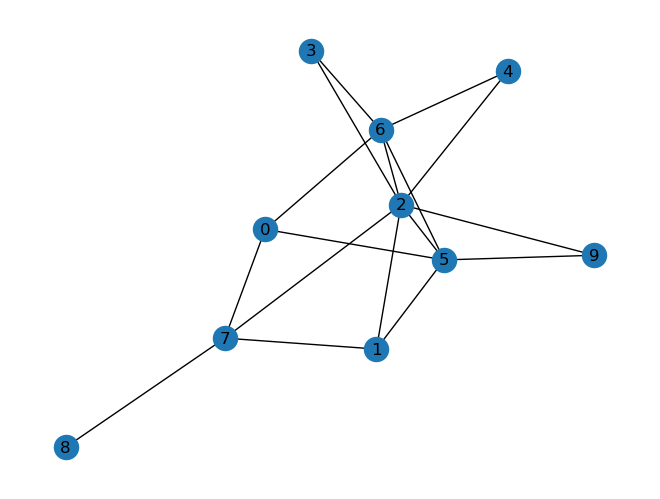

In [225]:
n = 10
A = make_test_graph(n, 0.4)
draw_graph(A)

In [226]:
x_0 = np.random.uniform(low=0.0, high=1.0, size=n)
x_0 /= np.sum(x_0)
x_hist, s_hist = frankwolfe(A=A, grad=maxclique_grad, lmo=maxclique_lmo, max_iter=10000, x_0=x_0)

In [233]:
x = x_hist[-1]
1./(1.-np.dot(np.dot(x.T,A),x))

1.0000000266639988

In [228]:
x

array([1.66716672e-01, 1.66583338e-01, 2.00020002e-08, 1.66616662e-01,
       1.66649985e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.66750015e-01, 1.66683308e-01])

In [229]:
maxclique_target(A,x)

0.08333336638705467

In [230]:
from scipy.optimize import minimize, rosen, rosen_der

In [231]:
bnds = [(0, None) for i_ in range(n)]
cons = ({'type': 'eq', 'fun': lambda x: x.sum()-1})

res = minimize(lambda x: -maxclique_target(A, x), x_0, method='SLSQP', bounds=bnds, constraints=cons)
x = res.x

In [232]:
1./(1.-np.dot(np.dot(x.T,A),x))

2.999999998927897